In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('data/mental_health_dataset.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (5000, 19)

First few rows:


,Age,Gender,Employment_Status,Chronic_Health_Issues,Screen_Time_hours_per_day,Sleep_Duration_hours_per_night,Sleep_Quality_1_to_10,Mood_Rating_1_to_10,Smoking_Habits,Drinking_Habits,Physical_Activity_hours_per_week,Diet_Quality_1_to_10,Social_Interaction_Level,Work_Study_Hours_per_day,Caffeine_Intake_mg_per_day,Depression_Level,Stress_Level,Anxiety_Presence,Mental_Health_Status
0,67,Female,Student,Yes,1.95,9.65,8.1,8.9,Never,Social,2.04,5.4,High,7.22,320.9,NaN,Low,No,Stable
1,28,Female,Unemployed,No,3.80,6.83,7.0,7.9,Never,Never,3.77,5.5,Medium,0.00,29.1,NaN,Low,No,Stable
2,35,Male,Employed,No,3.22,10.25,9.3,7.6,Never,Social,3.76,6.5,High,10.61,472.6,NaN,Medium,No,Stable
3,24,Male,Employed,No,3.41,4.36,3.2,5.6,Never,Social,6.56,5.9,Medium,10.29,470.2,Mild,Low,No,Stable
4,33,Female,Student,No,1.33,9.16,9.1,6.1,Occasionally,Social,4.24,4.7,High,5.19,239.8,NaN,Low,No,Stable


In [2]:
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nUnique values in target variables:")
print("Mental_Health_Status:", df['Mental_Health_Status'].value_counts())
print("\nDepression_Level:", df['Depression_Level'].value_counts())
print("\nAnxiety_Presence:", df['Anxiety_Presence'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               5000 non-null   int64  
 1   Gender                            5000 non-null   object 
 2   Employment_Status                 5000 non-null   object 
 3   Chronic_Health_Issues             5000 non-null   object 
 4   Screen_Time_hours_per_day         5000 non-null   float64
 5   Sleep_Duration_hours_per_night    5000 non-null   float64
 6   Sleep_Quality_1_to_10             5000 non-null   float64
 7   Mood_Rating_1_to_10               5000 non-null   float64
 8   Smoking_Habits                    5000 non-null   object 
 9   Drinking_Habits                   5000 non-null   object 
 10  Physical_Activity_hours_per_week  5000 non-null   float64
 11  Diet_Quality_1_to_10              5000 non-null   float

Statistical Summary:
               Age  Screen_Time_hours_per_day  Sleep_Duration_hours_per_night  \
count  5000.000000                5000.000000                     5000.000000   
mean     43.571800                   3.230088                        6.983194   
std      14.465791                   1.161378                        1.490775   
min      12.000000                   0.500000                        3.000000   
25%      32.000000                   2.440000                        5.950000   
50%      43.000000                   3.190000                        6.980000   
75%      55.000000                   3.940000                        8.000000   
max      70.000000                   8.370000                       11.000000   

       Sleep_Quality_1_to_10  Mood_Rating_1_to_10  \
count            5000.000000          5000.000000   
mean                5.984000             6.613880   
std                 1.767935             1.285715   
min                 1.000000         

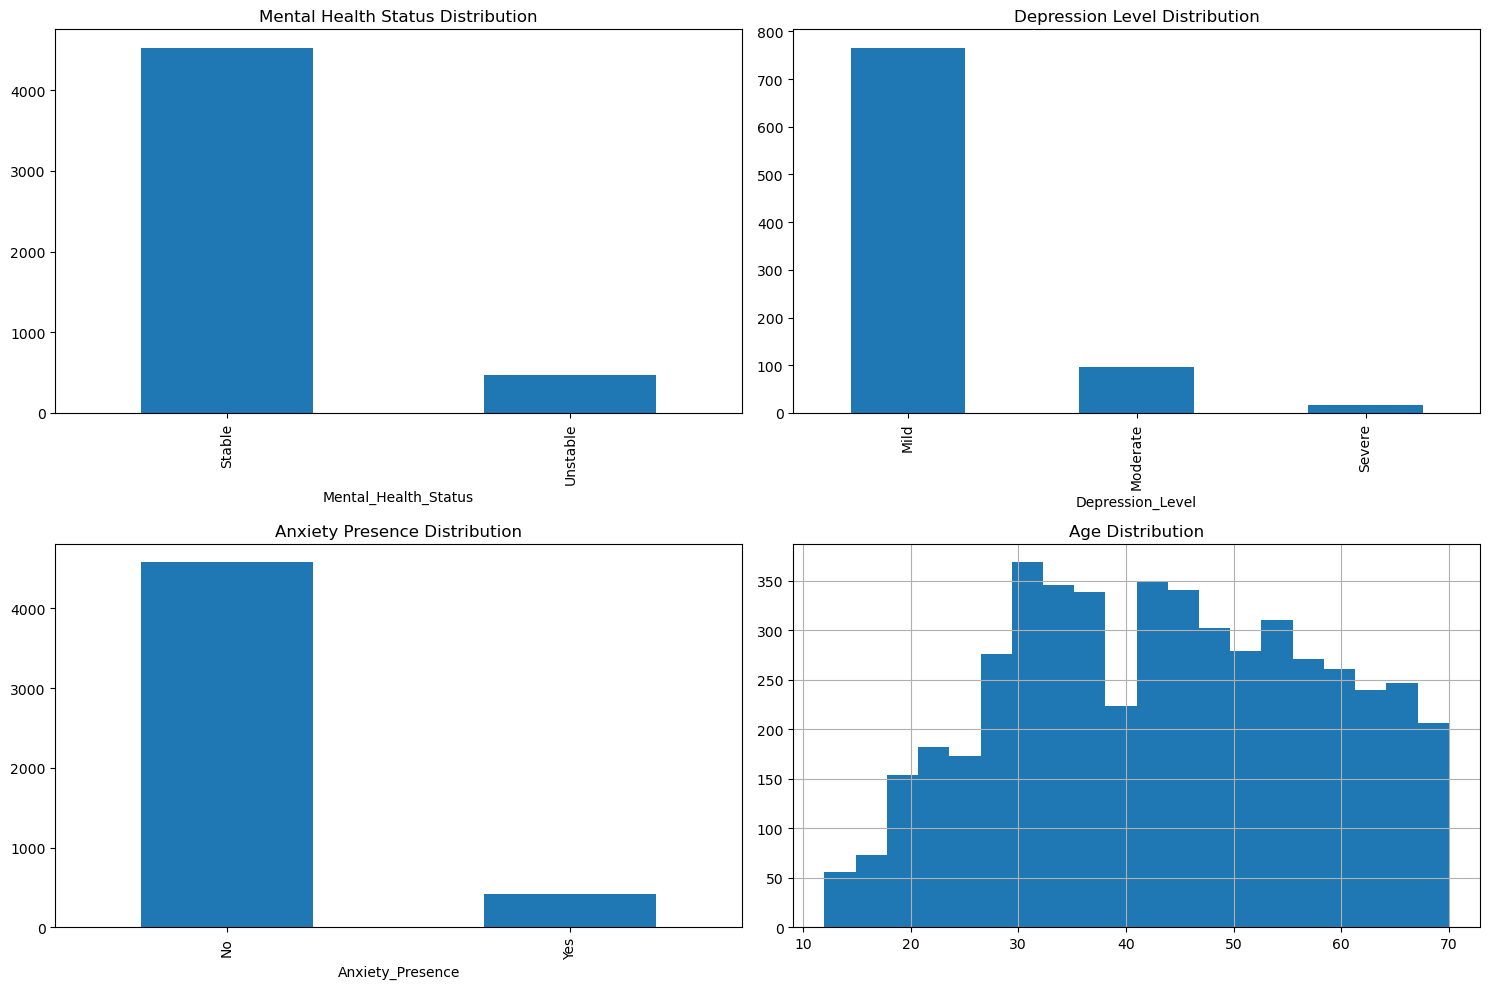

In [5]:
print("Statistical Summary:")
print(df.describe())

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target variable distributions
df['Mental_Health_Status'].value_counts().plot(kind='bar', ax=axes[0,0], title='Mental Health Status Distribution')
df['Depression_Level'].value_counts().plot(kind='bar', ax=axes[0,1], title='Depression Level Distribution')
df['Anxiety_Presence'].value_counts().plot(kind='bar', ax=axes[1,0], title='Anxiety Presence Distribution')

# Age distribution
df['Age'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Age Distribution')
plt.tight_layout()
plt.show()

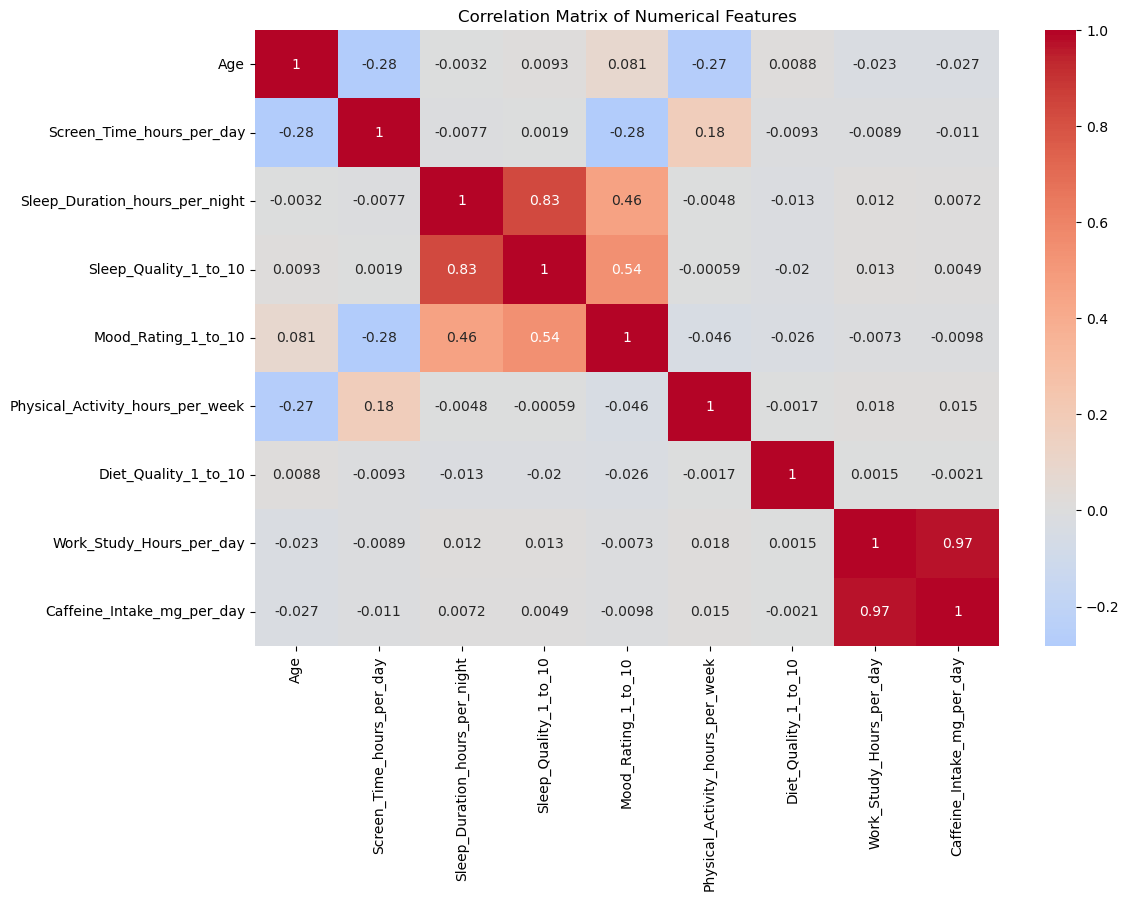

Selected features for modeling:
Numerical features: ['Age', 'Screen_Time_hours_per_day', 'Sleep_Duration_hours_per_night', 'Sleep_Quality_1_to_10', 'Mood_Rating_1_to_10', 'Physical_Activity_hours_per_week', 'Diet_Quality_1_to_10', 'Work_Study_Hours_per_day', 'Caffeine_Intake_mg_per_day']
Categorical features: ['Gender', 'Employment_Status', 'Chronic_Health_Issues', 'Smoking_Habits', 'Drinking_Habits', 'Social_Interaction_Level', 'Stress_Level']


In [6]:
numerical_features = ['Age', 'Screen_Time_hours_per_day', 'Sleep_Duration_hours_per_night', 
                     'Sleep_Quality_1_to_10', 'Mood_Rating_1_to_10', 'Physical_Activity_hours_per_week',
                     'Diet_Quality_1_to_10', 'Work_Study_Hours_per_day', 'Caffeine_Intake_mg_per_day']

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Feature importance analysis with respect to target variables
categorical_features = ['Gender', 'Employment_Status', 'Chronic_Health_Issues', 'Smoking_Habits', 
                       'Drinking_Habits', 'Social_Interaction_Level', 'Stress_Level']

print("Selected features for modeling:")
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)


In [7]:
# Create feature matrix X and target variables y
X_features = numerical_features + categorical_features
X = df[X_features].copy()

# Create target variables
y_mental_health = df['Mental_Health_Status']
y_depression = df['Depression_Level']
y_anxiety = df['Anxiety_Presence']

# Handle categorical variables
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
numerical_transformer = StandardScaler()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing pipeline created successfully")
print("Feature matrix shape:", X.shape)

Preprocessing pipeline created successfully
Feature matrix shape: (5000, 16)


In [8]:
# Split data for Mental Health Status
X_train_mh, X_test_mh, y_train_mh, y_test_mh = train_test_split(
    X, y_mental_health, test_size=0.2, random_state=42, stratify=y_mental_health)

# Create models for Mental Health Status
models_mh = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate models for Mental Health Status
results_mh = {}
for name, model in models_mh.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train model
    pipeline.fit(X_train_mh, y_train_mh)
    
    # Make predictions
    y_pred = pipeline.predict(X_test_mh)
    accuracy = accuracy_score(y_test_mh, y_pred)
    
    results_mh[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name} - Mental Health Status Accuracy: {accuracy:.4f}")

# Select best model for Mental Health Status
best_model_mh = max(results_mh, key=lambda x: results_mh[x]['accuracy'])
print(f"\nBest model for Mental Health Status: {best_model_mh}")

Random Forest - Mental Health Status Accuracy: 0.9150
Gradient Boosting - Mental Health Status Accuracy: 0.9150
Logistic Regression - Mental Health Status Accuracy: 0.9040
SVM - Mental Health Status Accuracy: 0.9100

Best model for Mental Health Status: Random Forest


In [12]:
print("Missing values in y_depression:", y_depression.isnull().sum())

# Remove rows with missing depression level
mask = y_depression.notna()
X_dep = X[mask]
y_depression_clean = y_depression[mask]

# Split data for Depression Level using cleaned data
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(
    X_dep, y_depression_clean, test_size=0.2, random_state=42, stratify=y_depression_clean)

# Train models for Depression Level
models_dep = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

results_dep = {}
for name, model in models_dep.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train_dep, y_train_dep)
    y_pred = pipeline.predict(X_test_dep)
    accuracy = accuracy_score(y_test_dep, y_pred)
    
    results_dep[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name} - Depression Level Accuracy: {accuracy:.4f}")

best_model_dep = max(results_dep, key=lambda x: results_dep[x]['accuracy'])
print(f"\nBest model for Depression Level: {best_model_dep}")

Missing values in y_depression: 4120
Random Forest - Depression Level Accuracy: 0.9375
Gradient Boosting - Depression Level Accuracy: 0.9943
Logistic Regression - Depression Level Accuracy: 0.9716
SVM - Depression Level Accuracy: 0.9716

Best model for Depression Level: Gradient Boosting


In [13]:
# Split data for Anxiety Presence
X_train_anx, X_test_anx, y_train_anx, y_test_anx = train_test_split(
    X, y_anxiety, test_size=0.2, random_state=42, stratify=y_anxiety)

# Train models for Anxiety Presence
models_anx = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

results_anx = {}
for name, model in models_anx.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train_anx, y_train_anx)
    y_pred = pipeline.predict(X_test_anx)
    accuracy = accuracy_score(y_test_anx, y_pred)
    
    results_anx[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"{name} - Anxiety Presence Accuracy: {accuracy:.4f}")

best_model_anx = max(results_anx, key=lambda x: results_anx[x]['accuracy'])
print(f"\nBest model for Anxiety Presence: {best_model_anx}")

Random Forest - Anxiety Presence Accuracy: 0.9160
Gradient Boosting - Anxiety Presence Accuracy: 0.9080
Logistic Regression - Anxiety Presence Accuracy: 0.9160
SVM - Anxiety Presence Accuracy: 0.9160

Best model for Anxiety Presence: Random Forest


DETAILED MODEL EVALUATION

1. MENTAL HEALTH STATUS PREDICTION
----------------------------------------
Best Model: Random Forest
Accuracy: 0.9150

Classification Report:
              precision    recall  f1-score   support

      Stable       0.92      1.00      0.96       906
    Unstable       0.76      0.14      0.23        94

    accuracy                           0.92      1000
   macro avg       0.84      0.57      0.59      1000
weighted avg       0.90      0.92      0.89      1000



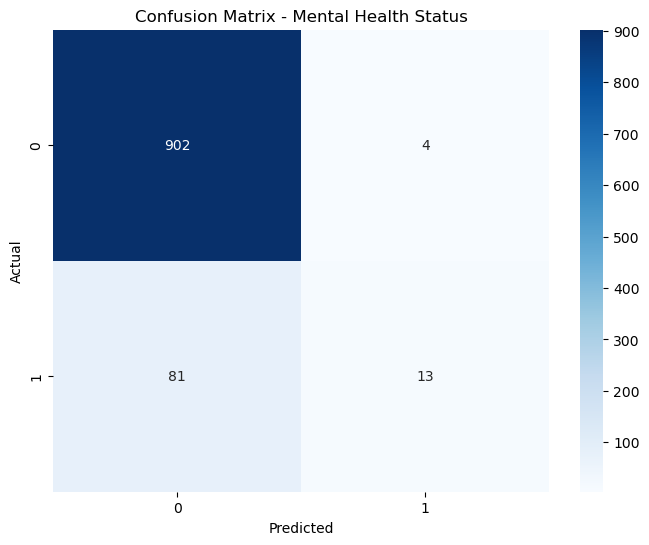


2. DEPRESSION LEVEL PREDICTION
----------------------------------------
Best Model: Gradient Boosting
Accuracy: 0.9943

Classification Report:
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       153
    Moderate       0.95      1.00      0.98        20
      Severe       1.00      0.67      0.80         3

    accuracy                           0.99       176
   macro avg       0.98      0.89      0.93       176
weighted avg       0.99      0.99      0.99       176



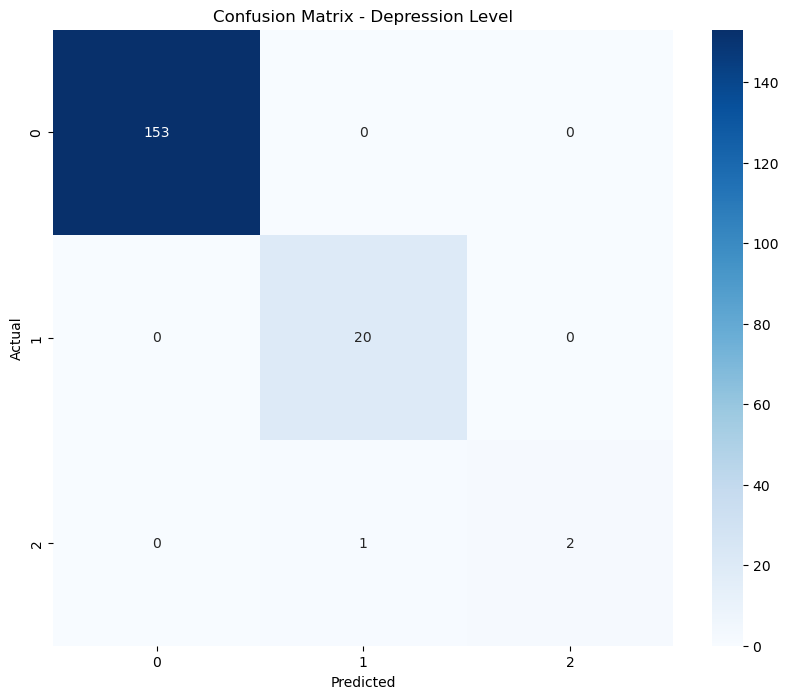


3. ANXIETY PRESENCE PREDICTION
----------------------------------------
Best Model: Random Forest
Accuracy: 0.9160

Classification Report:
              precision    recall  f1-score   support

          No       0.92      1.00      0.96       916
         Yes       0.50      0.02      0.05        84

    accuracy                           0.92      1000
   macro avg       0.71      0.51      0.50      1000
weighted avg       0.88      0.92      0.88      1000



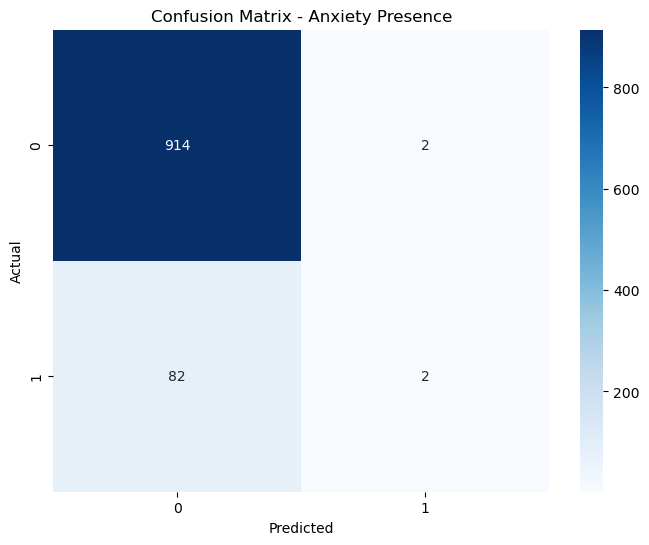

In [14]:
print("="*60)
print("DETAILED MODEL EVALUATION")
print("="*60)

# Mental Health Status evaluation
print("\n1. MENTAL HEALTH STATUS PREDICTION")
print("-" * 40)
best_mh_model = results_mh[best_model_mh]['model']
y_pred_mh = results_mh[best_model_mh]['predictions']

print(f"Best Model: {best_model_mh}")
print(f"Accuracy: {results_mh[best_model_mh]['accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_mh, y_pred_mh))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_mh = confusion_matrix(y_test_mh, y_pred_mh)
sns.heatmap(cm_mh, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Mental Health Status')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Depression Level evaluation
print("\n2. DEPRESSION LEVEL PREDICTION")
print("-" * 40)
best_dep_model = results_dep[best_model_dep]['model']
y_pred_dep = results_dep[best_model_dep]['predictions']

print(f"Best Model: {best_model_dep}")
print(f"Accuracy: {results_dep[best_model_dep]['accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_dep, y_pred_dep))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_dep = confusion_matrix(y_test_dep, y_pred_dep)
sns.heatmap(cm_dep, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Depression Level')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Anxiety Presence evaluation
print("\n3. ANXIETY PRESENCE PREDICTION")
print("-" * 40)
best_anx_model = results_anx[best_model_anx]['model']
y_pred_anx = results_anx[best_model_anx]['predictions']

print(f"Best Model: {best_model_anx}")
print(f"Accuracy: {results_anx[best_model_anx]['accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_anx, y_pred_anx))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_anx = confusion_matrix(y_test_anx, y_pred_anx)
sns.heatmap(cm_anx, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Anxiety Presence')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

FEATURE IMPORTANCE ANALYSIS


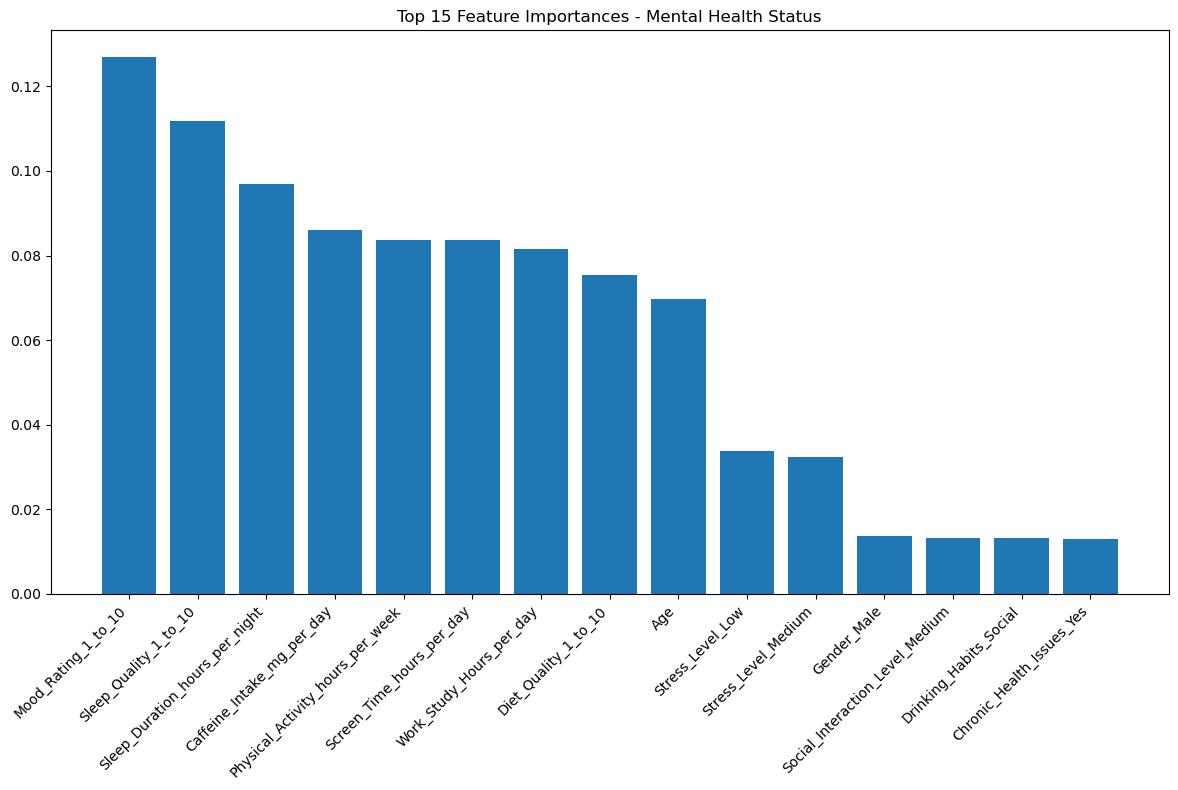


Top 10 Important Features for Mental Health Status:
1. Mood_Rating_1_to_10: 0.1269
2. Sleep_Quality_1_to_10: 0.1118
3. Sleep_Duration_hours_per_night: 0.0970
4. Caffeine_Intake_mg_per_day: 0.0859
5. Physical_Activity_hours_per_week: 0.0838
6. Screen_Time_hours_per_day: 0.0836
7. Work_Study_Hours_per_day: 0.0816
8. Diet_Quality_1_to_10: 0.0753
9. Age: 0.0696
10. Stress_Level_Low: 0.0337


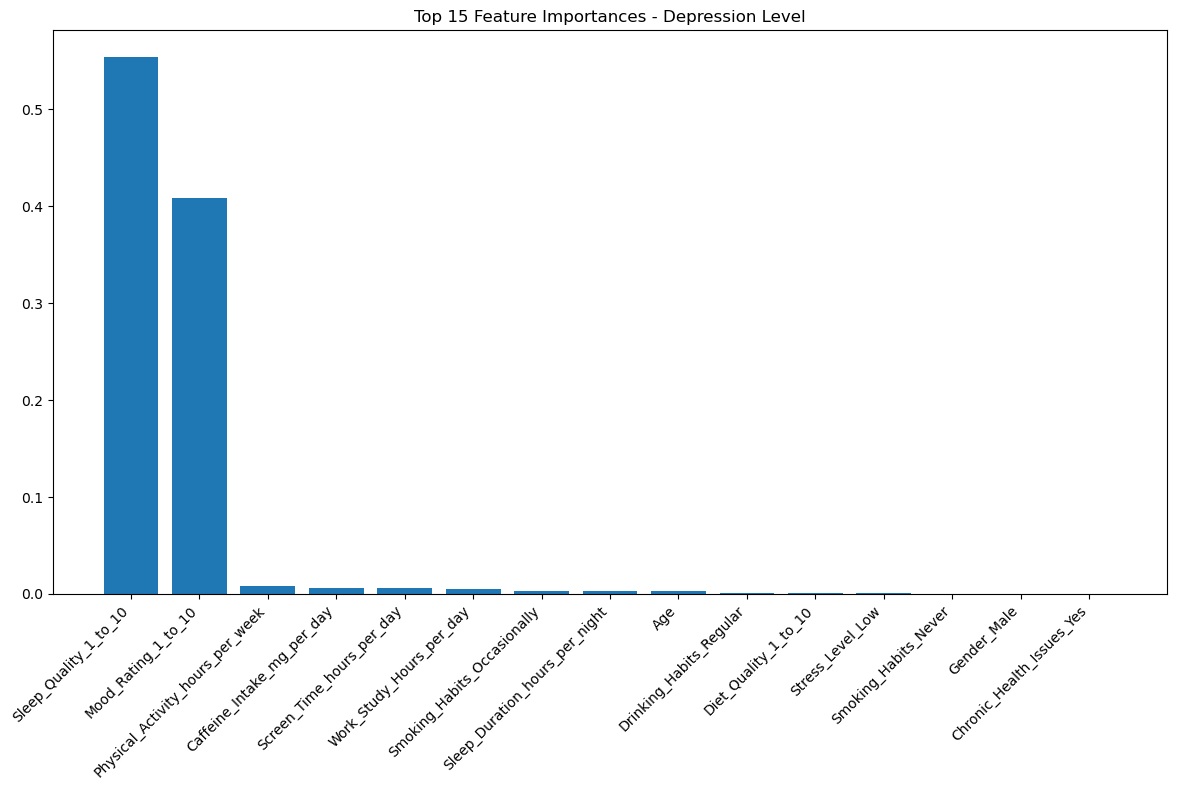


Top 10 Important Features for Depression Level:
1. Sleep_Quality_1_to_10: 0.5538
2. Mood_Rating_1_to_10: 0.4087
3. Physical_Activity_hours_per_week: 0.0077
4. Caffeine_Intake_mg_per_day: 0.0061
5. Screen_Time_hours_per_day: 0.0061
6. Work_Study_Hours_per_day: 0.0054
7. Smoking_Habits_Occasionally: 0.0029
8. Sleep_Duration_hours_per_night: 0.0029
9. Age: 0.0026
10. Drinking_Habits_Regular: 0.0013


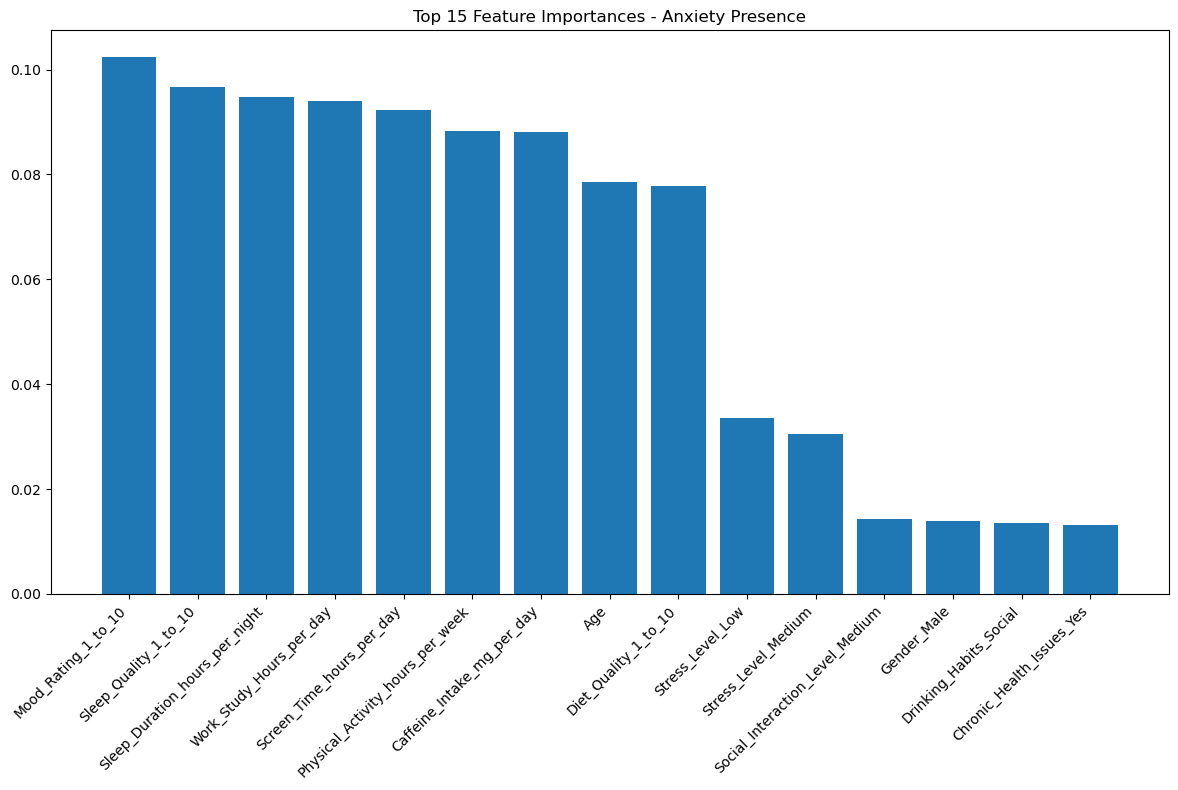


Top 10 Important Features for Anxiety Presence:
1. Mood_Rating_1_to_10: 0.1024
2. Sleep_Quality_1_to_10: 0.0967
3. Sleep_Duration_hours_per_night: 0.0948
4. Work_Study_Hours_per_day: 0.0940
5. Screen_Time_hours_per_day: 0.0924
6. Physical_Activity_hours_per_week: 0.0884
7. Caffeine_Intake_mg_per_day: 0.0882
8. Age: 0.0785
9. Diet_Quality_1_to_10: 0.0778
10. Stress_Level_Low: 0.0335


In [15]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature names after preprocessing
feature_names = (numerical_features + 
                list(best_mh_model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features)))

# Function to plot feature importance
def plot_feature_importance(model, feature_names, title):
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importances = model.named_steps['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # Top 15 features
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Top 15 Feature Importances - {title}')
        plt.bar(range(15), importances[indices])
        plt.xticks(range(15), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 10 Important Features for {title}:")
        for i in range(10):
            print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot feature importance for each best model
if hasattr(best_mh_model.named_steps['classifier'], 'feature_importances_'):
    plot_feature_importance(best_mh_model, feature_names, "Mental Health Status")

if hasattr(best_dep_model.named_steps['classifier'], 'feature_importances_'):
    plot_feature_importance(best_dep_model, feature_names, "Depression Level")

if hasattr(best_anx_model.named_steps['classifier'], 'feature_importances_'):
    plot_feature_importance(best_anx_model, feature_names, "Anxiety Presence")


In [17]:
print("="*60)
print("CROSS-VALIDATION RESULTS")
print("="*60)

# Create cleaned datasets for each target
mask_mh = y_mental_health.notna()
X_mh = X[mask_mh]
y_mh = y_mental_health[mask_mh]

mask_dep = y_depression.notna()
X_dep = X[mask_dep]
y_dep = y_depression[mask_dep]

mask_anx = y_anxiety.notna()
X_anx = X[mask_anx]
y_anx = y_anxiety[mask_anx]

# Perform cross-validation for best models using CLEANED data
cv_scores_mh = cross_val_score(best_mh_model, X_mh, y_mh, cv=5, scoring='accuracy')
cv_scores_dep = cross_val_score(best_dep_model, X_dep, y_dep, cv=5, scoring='accuracy')
cv_scores_anx = cross_val_score(best_anx_model, X_anx, y_anx, cv=5, scoring='accuracy')

print("Mental Health Status - Cross-validation scores:")
print(f"Scores: {cv_scores_mh}")
print(f"Mean CV Accuracy: {cv_scores_mh.mean():.4f} (+/- {cv_scores_mh.std() * 2:.4f})")

print("\nDepression Level - Cross-validation scores:")
print(f"Scores: {cv_scores_dep}")
print(f"Mean CV Accuracy: {cv_scores_dep.mean():.4f} (+/- {cv_scores_dep.std() * 2:.4f})")

print("\nAnxiety Presence - Cross-validation scores:")
print(f"Scores: {cv_scores_anx}")
print(f"Mean CV Accuracy: {cv_scores_anx.mean():.4f} (+/- {cv_scores_anx.std() * 2:.4f})")

CROSS-VALIDATION RESULTS
Mental Health Status - Cross-validation scores:
Scores: [0.92  0.912 0.911 0.909 0.915]
Mean CV Accuracy: 0.9134 (+/- 0.0077)

Depression Level - Cross-validation scores:
Scores: [0.97159091 0.96590909 0.97727273 0.98863636 0.96590909]
Mean CV Accuracy: 0.9739 (+/- 0.0170)

Anxiety Presence - Cross-validation scores:
Scores: [0.916 0.916 0.917 0.917 0.914]
Mean CV Accuracy: 0.9160 (+/- 0.0022)


In [18]:
print("="*80)
print("FINAL MODEL SUMMARY")
print("="*80)

summary_data = {
    'Target Variable': ['Mental Health Status', 'Depression Level', 'Anxiety Presence'],
    'Best Model': [best_model_mh, best_model_dep, best_model_anx],
    'Test Accuracy': [
        f"{results_mh[best_model_mh]['accuracy']:.4f}",
        f"{results_dep[best_model_dep]['accuracy']:.4f}",
        f"{results_anx[best_model_anx]['accuracy']:.4f}"
    ],
    'CV Mean Accuracy': [
        f"{cv_scores_mh.mean():.4f}",
        f"{cv_scores_dep.mean():.4f}",
        f"{cv_scores_anx.mean():.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\nTotal number of samples: {len(df)}")
print(f"Number of features used: {len(X_features)}")
print(f"Train-Test split: 80-20")

FINAL MODEL SUMMARY
     Target Variable        Best Model Test Accuracy CV Mean Accuracy
Mental Health Status     Random Forest        0.9150           0.9134
    Depression Level Gradient Boosting        0.9943           0.9739
    Anxiety Presence     Random Forest        0.9160           0.9160

Total number of samples: 5000
Number of features used: 16
Train-Test split: 80-20


In [21]:
import os
import joblib

# Create folder if it doesn't exist
model_dir = "mental_health_models"
os.makedirs(model_dir, exist_ok=True)

print("="*60)
print("EXPORTING MODELS TO 'mental_health_models' FOLDER")
print("="*60)

# Save models with updated paths
model_files = {
    'mental_health_model.joblib': best_mh_model,
    'depression_model.joblib': best_dep_model,
    'anxiety_model.joblib': best_anx_model
}

for filename, model in model_files.items():
    filepath = os.path.join(model_dir, filename)
    joblib.dump(model, filepath)
    print(f"✓ Saved {filepath}")

# Save feature names
feature_path = os.path.join(model_dir, 'feature_names.joblib')
joblib.dump(X_features, feature_path)
print(f"✓ Saved {feature_path}")

# Save model info
model_info = {
    'feature_columns': X_features,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'model_performance': {
        'mental_health': {
            'model_name': best_model_mh,
            'accuracy': results_mh[best_model_mh]['accuracy'],
            'cv_mean': cv_scores_mh.mean()
        },
        'depression': {
            'model_name': best_model_dep,
            'accuracy': results_dep[best_model_dep]['accuracy'],
            'cv_mean': cv_scores_dep.mean()
        },
        'anxiety': {
            'model_name': best_model_anx,
            'accuracy': results_anx[best_model_anx]['accuracy'],
            'cv_mean': cv_scores_anx.mean()
        }
    }
}

info_path = os.path.join(model_dir, 'model_info.joblib')
joblib.dump(model_info, info_path)
print(f"✓ Saved {info_path}")

# Success message
print(f"\nAll models exported successfully to '{model_dir}/'!")
print("Files created:")
print(f"- {model_dir}/mental_health_model.joblib")
print(f"- {model_dir}/depression_model.joblib")
print(f"- {model_dir}/anxiety_model.joblib")
print(f"- {model_dir}/feature_names.joblib")
print(f"- {model_dir}/model_info.joblib")

print("\nThese models are ready to be used in your Flask application!")

EXPORTING MODELS TO 'mental_health_models' FOLDER
✓ Saved mental_health_models\mental_health_model.joblib
✓ Saved mental_health_models\depression_model.joblib
✓ Saved mental_health_models\anxiety_model.joblib
✓ Saved mental_health_models\feature_names.joblib
✓ Saved mental_health_models\model_info.joblib

All models exported successfully to 'mental_health_models/'!
Files created:
- mental_health_models/mental_health_model.joblib
- mental_health_models/depression_model.joblib
- mental_health_models/anxiety_model.joblib
- mental_health_models/feature_names.joblib
- mental_health_models/model_info.joblib

These models are ready to be used in your Flask application!


In [20]:
def predict_mental_health(input_data):
    """
    Example function showing how to use the saved models for prediction
    input_data should be a dictionary with feature names as keys
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Make predictions
    mh_pred = best_mh_model.predict(input_df[X_features])[0]
    dep_pred = best_dep_model.predict(input_df[X_features])[0]
    anx_pred = best_anx_model.predict(input_df[X_features])[0]
    
    # Get prediction probabilities
    mh_prob = best_mh_model.predict_proba(input_df[X_features])[0].max()
    dep_prob = best_dep_model.predict_proba(input_df[X_features])[0].max()
    anx_prob = best_anx_model.predict_proba(input_df[X_features])[0].max()
    
    return {
        'mental_health_status': mh_pred,
        'depression_level': dep_pred,
        'anxiety_presence': anx_pred,
        'mental_health_confidence': mh_prob,
        'depression_confidence': dep_prob,
        'anxiety_confidence': anx_prob
    }

# Example usage
sample_input = {
    'Age': 30,
    'Gender': 'Male',
    'Employment_Status': 'Employed',
    'Chronic_Health_Issues': 'No',
    'Screen_Time_hours_per_day': 4.0,
    'Sleep_Duration_hours_per_night': 7.0,
    'Sleep_Quality_1_to_10': 7.0,
    'Mood_Rating_1_to_10': 6.0,
    'Smoking_Habits': 'Never',
    'Drinking_Habits': 'Social',
    'Physical_Activity_hours_per_week': 3.0,
    'Diet_Quality_1_to_10': 6.0,
    'Social_Interaction_Level': 'Medium',
    'Work_Study_Hours_per_day': 8.0,
    'Caffeine_Intake_mg_per_day': 200.0,
    'Stress_Level': 'Medium'
}

print("="*60)
print("EXAMPLE PREDICTION")
print("="*60)
result = predict_mental_health(sample_input)
print("Sample Input:", sample_input)
print("\nPrediction Results:")
for key, value in result.items():
    print(f"{key}: {value}")

print("\n" + "="*80)
print("MACHINE LEARNING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)

EXAMPLE PREDICTION
Sample Input: {'Age': 30, 'Gender': 'Male', 'Employment_Status': 'Employed', 'Chronic_Health_Issues': 'No', 'Screen_Time_hours_per_day': 4.0, 'Sleep_Duration_hours_per_night': 7.0, 'Sleep_Quality_1_to_10': 7.0, 'Mood_Rating_1_to_10': 6.0, 'Smoking_Habits': 'Never', 'Drinking_Habits': 'Social', 'Physical_Activity_hours_per_week': 3.0, 'Diet_Quality_1_to_10': 6.0, 'Social_Interaction_Level': 'Medium', 'Work_Study_Hours_per_day': 8.0, 'Caffeine_Intake_mg_per_day': 200.0, 'Stress_Level': 'Medium'}

Prediction Results:
mental_health_status: Stable
depression_level: Mild
anxiety_presence: No
mental_health_confidence: 0.93
depression_confidence: 0.9999606558771229
anxiety_confidence: 0.94

MACHINE LEARNING PIPELINE COMPLETED SUCCESSFULLY!


In [22]:
def predict_mental_health(input_data):
    """
    Example function showing how to use the saved models for prediction
    input_data should be a dictionary with feature names as keys
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Make predictions
    mh_pred = best_mh_model.predict(input_df[X_features])[0]
    dep_pred = best_dep_model.predict(input_df[X_features])[0]
    anx_pred = best_anx_model.predict(input_df[X_features])[0]
    
    # Get prediction probabilities
    mh_prob = best_mh_model.predict_proba(input_df[X_features])[0].max()
    dep_prob = best_dep_model.predict_proba(input_df[X_features])[0].max()
    anx_prob = best_anx_model.predict_proba(input_df[X_features])[0].max()
    
    return {
        'mental_health_status': mh_pred,
        'depression_level': dep_pred,
        'anxiety_presence': anx_pred,
        'mental_health_confidence': mh_prob,
        'depression_confidence': dep_prob,
        'anxiety_confidence': anx_prob
    }

# Example usage
sample_input = {
    'Age': 30,
    'Gender': 'Male',
    'Employment_Status': 'Employed',
    'Chronic_Health_Issues': 'No',
    'Screen_Time_hours_per_day': 4.0,
    'Sleep_Duration_hours_per_night': 7.0,
    'Sleep_Quality_1_to_10': 7.0,
    'Mood_Rating_1_to_10': 6.0,
    'Smoking_Habits': 'Never',
    'Drinking_Habits': 'Social',
    'Physical_Activity_hours_per_week': 3.0,
    'Diet_Quality_1_to_10': 6.0,
    'Social_Interaction_Level': 'Medium',
    'Work_Study_Hours_per_day': 8.0,
    'Caffeine_Intake_mg_per_day': 200.0,
    'Stress_Level': 'Medium'
}

print("="*60)
print("EXAMPLE PREDICTION")
print("="*60)
result = predict_mental_health(sample_input)
print("Sample Input:", sample_input)
print("\nPrediction Results:")
for key, value in result.items():
    print(f"{key}: {value}")

print("\n" + "="*80)
print("MACHINE LEARNING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)

EXAMPLE PREDICTION
Sample Input: {'Age': 30, 'Gender': 'Male', 'Employment_Status': 'Employed', 'Chronic_Health_Issues': 'No', 'Screen_Time_hours_per_day': 4.0, 'Sleep_Duration_hours_per_night': 7.0, 'Sleep_Quality_1_to_10': 7.0, 'Mood_Rating_1_to_10': 6.0, 'Smoking_Habits': 'Never', 'Drinking_Habits': 'Social', 'Physical_Activity_hours_per_week': 3.0, 'Diet_Quality_1_to_10': 6.0, 'Social_Interaction_Level': 'Medium', 'Work_Study_Hours_per_day': 8.0, 'Caffeine_Intake_mg_per_day': 200.0, 'Stress_Level': 'Medium'}

Prediction Results:
mental_health_status: Stable
depression_level: Mild
anxiety_presence: No
mental_health_confidence: 0.93
depression_confidence: 0.9999606558771229
anxiety_confidence: 0.94

MACHINE LEARNING PIPELINE COMPLETED SUCCESSFULLY!
